<h1><center>How was last year? Exploring New York Times world news over 1 year time span</center></h1>

## 6.3 Conclusion and further work

Coming back the core of this study I reckon that being able to evaluate how the past year has been is easier to tell than to put in practice - especially from a machine standpoint. Even though there were not great unexpected findings it was interesting to find out how Covid is monopolizing the world newsand many other interesting topics have been partially eclipsed as for example for the climate topic. Sentiment analysis is a great tool but as far as this can be developed there will always be some flaws. Trying to sum up 12 month and making a computer "judge" on the times we are living is somewhat funny and intriguing at the same time. Even if it was not a surprise that the compound result of our analysis has been negative, I always ask myself, with a bit of a smile, whether newspapers ever give positive news in the first place. Of course they do but the negative ones outnumber the positive by far. It might be that we need to take a break from the news and live our life less influenced by them? This might be probably a good way to avoid absorbing less negativity, especially considering how depression, panic and anxiety have affected people during this period of lock down. Perhaps being a bit disconnected in a super connected world is not a bad idea.

Given these results, further work could focus more on sentiment analysis insights and the frequency of some words. For example analyze how different topics and sections have different sentiment analysis scores or in which topics certain words are most present. Also would be interesting to see how sentiment analysis evolved in time, analyzing for example what happened in that day in respect to an outlier negative or positive value. It would be interesting to see how the presence of some countries in the keywords chart evolved over time - expecting an evolution of the relevant countries in time due to the spread of the virus.

# Part 2

## 7 - Introduction

We left our first part of the study with a picture of what happened in a 12 months time span basing our judgment on sentiment analysis, wordclouds and word frequencies using the world news from the NYT. The study also gave us a picture of what were the main topics, words and sections. It left us with some questions though that we are going to try to answer now. For example: how do different topics and sections have different sentiment analysis scores? How sentiment analysis evolved in time? Could we infer any pattern? What happened in those days where we had an extreme positive or negative value?

To achieve this goal we will try to reduce the granularity of our findings and have a finer look on smaller details. We will analyze wordclouds and word frequencies for shorter time frames, also we will focus our attention on keywords sentiment score. Furthermore, since one of the main question marks was if we can use the sentiment analysis as a reliable source of inference of the "status" of the world, we will perform a time series analysis to understand if there's any pattern or seasonability of the bad and good news. 

Finally, we will see if we can perform a trend forecasting based on a news topic (eg. Coronavirus) and if this is then reflected in future facts and if there is a correlation between the topic and the value of sentiment analysis.

After we will move our attention on sentiment analysis based on the subsection geography, checking which continent or zone fo the world "performed" best or worse during these 12 months in terms of good and bad news and which words have been used the most respectively. This could give us some insight of what different countries have been on and what were the main topics for them.

Since we will rely heavily on sentiment analysis score to make our final conclusions I want to point out how, compared to part one of the study, this time it could be easier that there could be some findings that could lead to some harmful assumptions.This could end up for example giving a negative outcome for a country compared to others. Given this we need to be aware of sentiment analysis bias. Citing "Examining Gender and Race Bias in Sentiment Analysis Systems": [[1]](#references_)

>Automatic systems are beneficial to society but as they improve in predictive performance, comparable to human capabilities, they could perpetuate inappropriate human biases. In the context of sentiment analysis (SA), these biases may come in many forms. For instance, an SA system may consider the messages conveyed by a specific gender or race to be less positive simply because of their race and gender. Therefore, even when it is not clear how biases are manifested, it is the duty and responsibility of the natural language processing (NLP) system developer to address this problem.

At the end of his study it has been concluded that a strong bias was detected and that race bias was more prevalent than gender bias. Thus, given this inputs we need to carefully consider the results that sentiment analysis will give us.

Let's start importing all the libraries:

In [1]:
#import libraries and modules
import datetime
import requests
import unittest
from ast import literal_eval
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from ast import literal_eval
from dateutil.parser import parse
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud
from textblob import TextBlob

from transformers import AutoTokenizer, AutoModelForSequenceClassification, DistilBertForSequenceClassification, DistilBertTokenizer
import torch

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import plotly.express as px
import altair as alt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\massi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We will parse the date column to be able to do some time series analysis:

In [2]:
df = pd.read_csv("articles_world_2.csv", parse_dates=["date"])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6266 entries, 0 to 6265
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   headline          6266 non-null   object        
 1   print_headline    3362 non-null   object        
 2   lead_paragraph    6243 non-null   object        
 3   abstract          6262 non-null   object        
 4   document_type     6266 non-null   object        
 5   type_of_material  6266 non-null   object        
 6   keywords          6266 non-null   object        
 7   news_desk         6266 non-null   object        
 8   section_name      6266 non-null   object        
 9   subsection_name   6266 non-null   object        
 10  word_count        6266 non-null   int64         
 11  date              6266 non-null   datetime64[ns]
 12  corpuses          6266 non-null   object        
 13  negative          6266 non-null   float64       
 14  neutral           6266 n

Some values are Null but they won't be used for the scope of this analysis

In [4]:
#Set date as index
df.set_index("date", inplace=True)

## 8 Time Series Analysis

Formally, time series is a sequence of observations recorded at regular time intervals. Depending on the frequency of observations, a time series may typically be hourly, daily, weekly, monthly, quarterly and annual.[[2]](#references_)

There are four components of time-series data:
* Data on time trends
* Seasonality in the data
* Non-linear or Structural Breaks
* Noise





### 8.1 Word Cloud and Word Frequency

We start from the conclusions of part 1 of the study. In particular we will have a look at the monthly results for the Word Cloud graphs and word frequency for the world news. 

In [5]:
#creating a dataframe with the various corpuses per each month
df_months = df.pivot_table(index=df.index.month, values="corpuses", aggfunc="sum")

In [6]:
#creating the months list for visualization
month_list = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December - 2020"    
    ]

months = list(enumerate(month_list))
    

Calling the text_cleaner function used in part 1 and adding "governament", "country" and "one" to the stopwords list to have a clearer view of predominant topics.

In [7]:
#let's create a text ceaner function to porcess our text
def text_cleaner(text):
    """
    This function preprocess the text returning a string.
    
    It applies the following steps in this order: 
    punctuation removal, tokenization, removal of stop words, lemmatization.
    
    Args:
        text (str): text to be preprocessed

    Returns:
        str: processed text
    """
    
    try:
        
        if type(text)==int or type(text)==float and not np.isnan(text):
            text=str(text)
            
        #Tokenize text
        # let's create a pattern to ignore
               
        pattern = r'''(?x)     # set flag to allow verbose regexps
        (?:[A-Z]\.)+       # abbreviations, e.g. U.S.
        | \w+(?:-\w+)*       # words with optional internal hyphens
        '''
        
        #create tokens excluding the pattern we just created
        tokens = nltk.regexp_tokenize(text, pattern) #tokenized text
                
        #Remove Stopwords - we apply this to normalized words
        stop_words = stopwords.words("english")
        stop_words.extend(["said","say","see", "new","say", "’", "‘","“", "”", "country", ".", "government", "one"]) #added stopwords to list
        filtered_text = [word.rstrip().lstrip().lower() for word in tokens if word.lower() not in stop_words] #rstrip().lstrip() to remove white spaces at the end and beginning fo the word
        
        #Lemmatize text - we want to keep the meaning of the words
        wordnet_lemmatizer  = WordNetLemmatizer()
        lemmatized_text = [wordnet_lemmatizer.lemmatize(word) for word in filtered_text ]
        
        return " ".join(lemmatized_text)
        
    except Exception as e:
        print("Sorry", e)
        return None
    
    

#### Unit Test

In [8]:
class TextCleaner(unittest.TestCase):
    def test_text_exists(self):
        """Asserting function exists
        """
        self.assertIsNotNone(text_cleaner)
        
    def test_returns_string(self):
        """Asserting that is returning text
        """
        res = text_cleaner("This is a test")
        self.assertEqual(type(res), str)
        
    def test_nonexistent(self):
        """Asserting that None returns None
        """
        res=text_cleaner(None)
        self.assertIsNone(res)
        
    def test_isnot_nan(self):
        """Asserting that np.nan is treated as None
        """
        res=text_cleaner(np.nan)
        self.assertIsNone(res)
        
    def test_not_text(self):
        """Asserting that int or float input is treated correctly and converted to string
        """
        res=text_cleaner(123)
        self.assertEqual(type(res), str)
        
    def test_lower(self):
        """Asserting text gets normalized
        """
        res=text_cleaner("Test")
        self.assertEqual(res, "test")
        
    def test_abbreviation_cleaning(self):
        """Assert that names and countries abbreviations don't get separated
        """
        res=text_cleaner("U.S.")
        self.assertEqual(res, "u.s.")
    
    def test_hyphens(self):
        """Assert that hyphens don't get removed
        """
        res=text_cleaner("covid-test")
        self.assertEqual(res, "covid-test")
        
    def test_stopwords(self):
        """Asserting stopwords get removed
        """
        res=text_cleaner("Hello. This is a test")
        self.assertEqual(res, "hello test")
        
    def test_lemmatized(self):
        """Assert text gets lemmatized
        """
        res=text_cleaner("units tests")
        self.assertNotEqual(res, "units tests")

unittest.main(argv=['ingored', '-v'], exit=False)

test_abbreviation_cleaning (__main__.TextCleaner)
Assert that names and countries abbreviations don't get separated ... ok
test_hyphens (__main__.TextCleaner)
Assert that hyphens don't get removed ... ok
test_isnot_nan (__main__.TextCleaner)
Asserting that np.nan is treated as None ... ok
test_lemmatized (__main__.TextCleaner)
Assert text gets lemmatized ... ok
test_lower (__main__.TextCleaner)
Asserting text gets normalized ... ok
test_nonexistent (__main__.TextCleaner)
Asserting that None returns None ... ok
test_not_text (__main__.TextCleaner)
Asserting that int or float input is treated correctly and converted to string ... ok
test_returns_string (__main__.TextCleaner)
Asserting that is returning text ... ok
test_stopwords (__main__.TextCleaner)
Asserting stopwords get removed ... ok
test_text_exists (__main__.TextCleaner)
Asserting function exists ... 

Sorry expected string or bytes-like object
Sorry expected string or bytes-like object


ok

----------------------------------------------------------------------
Ran 10 tests in 2.244s

OK


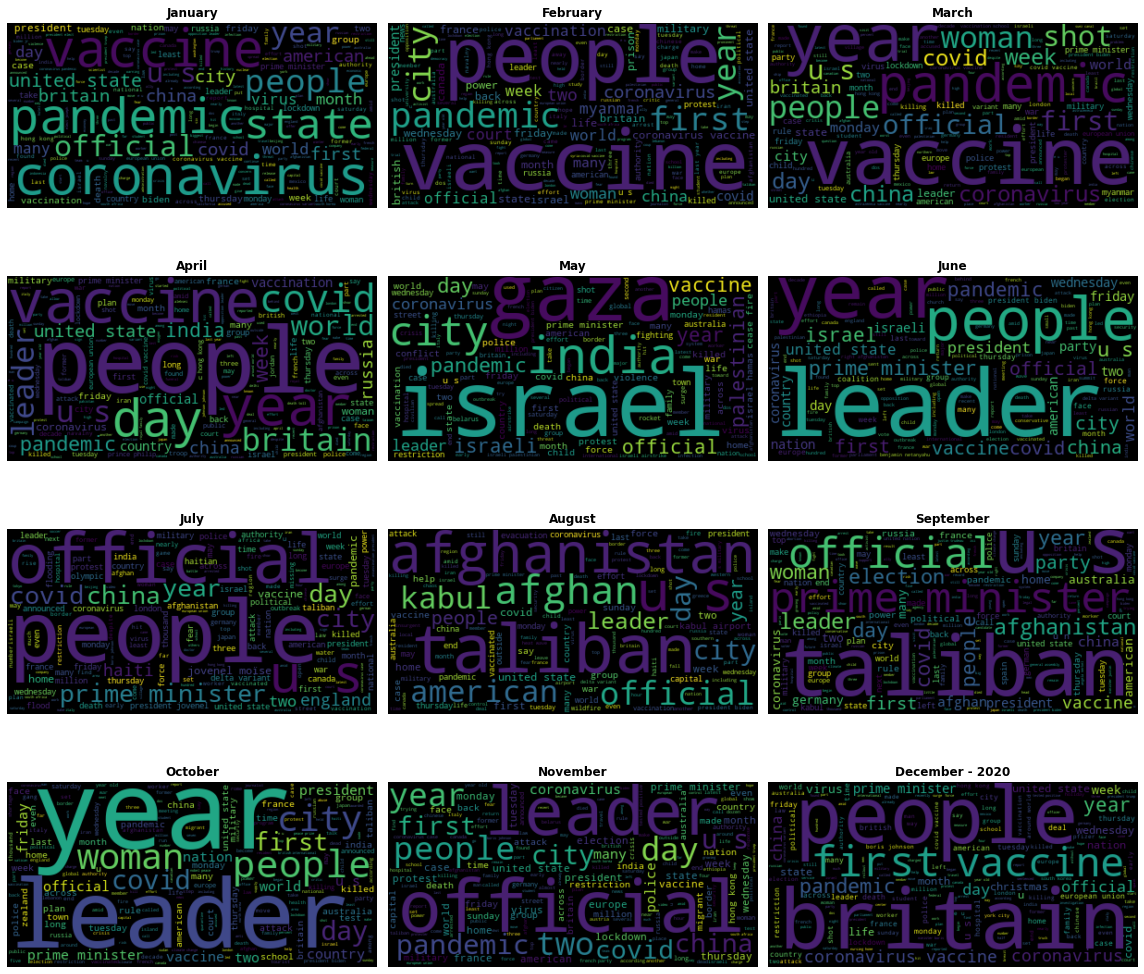

In [9]:
fig, ax = plt.subplots(nrows=4,ncols=3, figsize=(16,16))
ax=ax.ravel()

for month, a in enumerate(ax):
    wordcloud = WordCloud(random_state=42).generate(text_cleaner(df_months.loc[month+1, "corpuses"]))
    a.imshow(wordcloud, interpolation='bilinear')
    a.set_title(months[month][1], weight="bold")
    a.axis('off')
    plt.tight_layout()

It is interesting to note how most of the months are characterized by a supremacy of the presence of Covid related words. But we can see as well that in some of the months there are different prominent topics. In May for example, Gaza and Israel are the main topics - that's because of the raid on Aqsa Mosque. August and September are more focused on Afghanistan - that's a consequence of the Taliban reconquering the capital of the country. In December, the U.K. was the main topic due to the fact that was one of the main countries rolling out vaccines in Europe (please note that December refers to 2020).

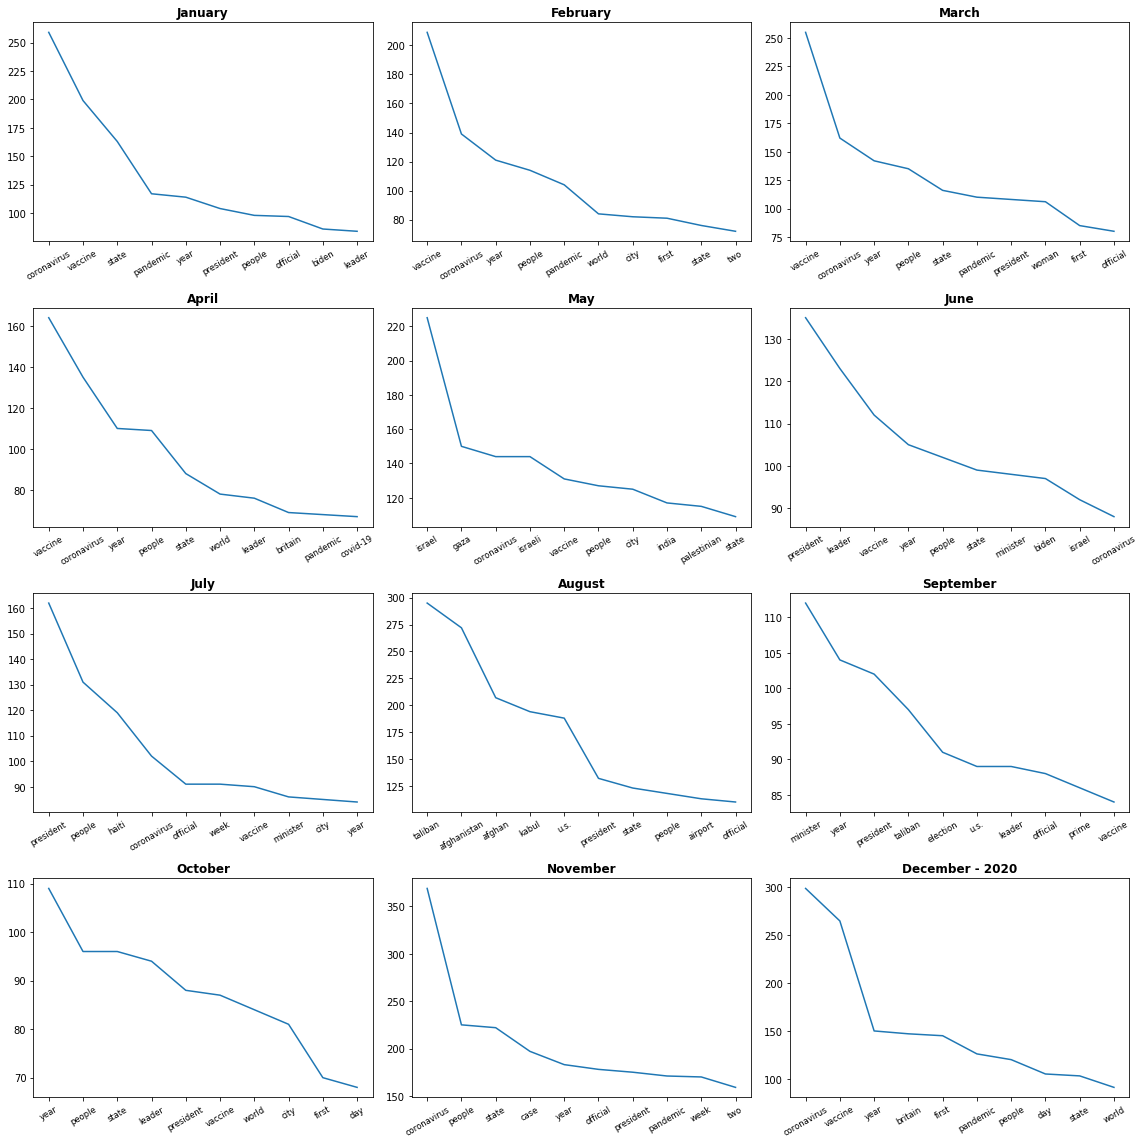

In [10]:
fig, ax = plt.subplots(nrows=4,ncols=3, figsize=(16,16))
ax=ax.ravel() #smoothing the list

for month, a in enumerate(ax):
    f_dist = FreqDist(nltk.tokenize.word_tokenize(text_cleaner(df_months.loc[month+1, "corpuses"])))
    a.plot(*zip(*f_dist.most_common(10))) #tuple unpacking for plotting
    a.set_xticklabels(list(zip(*f_dist.most_common(10)))[0], rotation=30, fontsize="small")
    a.set_title(months[month][1], weight="bold")
    plt.tight_layout()


Despite the use of the Word Cloud graphs, we can filter out the Covid related words to try to see what has been the main topic during that time. For example we can see how February has Myanmar as one of the main utilized words -  this is because of the military coup. Also, Haiti is the most used word in July, that's because of the assassination of its President.

### 8.2 Defining the Time Series

I have never performed a time series analysis before, but there always be a first time and since I wanted to try to make some deductions out of my data I understood that I had to dive deeper into this topic. There isn't any claim of being able to predict good or bad news but we'll try to demonstrate if we can spot any pattern or trend in the sentiment analysis, I want to understand if bad or good news repeat over time in a cyclic manner or if we can spot any anomaly in the data.

First of all we will analyze the kind of data we are dealing with. We will first try to acknowledge if the data is stationary or not because this makes time series analysis easier [[3]](#references_) where a stationary time series is one in which all its statistical characteristics remain unchanged over time [[4]](#references_). Also, knowing time series statistical properties will help us to disclose if the time series is white noise or random walk alike. More in general we can classify the two as follows:

* White noise:  A time series is white noise when sequence of uncorrelated random variables that are identically distributed. [[5]](#references_)
* Random walk: A random walk is another time series model where the current observation is equal to the previous observation with a noise. [[5]](#references_)

The following conditions must be satisfied for a time series to be classified as white noise:
* The mean value is zero
* Standard deviation is constant — it doesn’t change over time
* The correlation between time series and its lagged version is not significant

While to classify a random walk these are the conditions: [[6]](#references_)
* Non zero mean
* Non constant standard deviation
* Plot looks like a regular distribution

I am expecting our time series to be in the middle between white noise and random walk. This is because our time series could be very white noise alike but with some random walk characteristics since the value of the following sentiment day could be influenced by the noise caused by the news of the previous day.

So given these conditions, we will:
* Plot the time series
* Compare mean and standard deviation over time
* Examining autocorrelation plots

In [11]:
#creating a new dataframe
sentiment_df = df.groupby(df.index.date)["negative", "neutral", "positive", "compound"].mean()

#### 8.2.1 Stationary Time Series

A quick way to recognize if we are dealing with stationary data is by performing an ADF (Augmented Dicky Fuller) or a KPSS (Kwiatkowski–Phillips–Schmidt–Shin) test. ADF assume the following hypothesis:

* Null hypothesis is that the time series is non-stationary.
* Alternate hypothesis is that the time series is non-stationary.

KPSS exactly the opposite, so consequently the p value have opposite meaning. That is, if p-value is < significance level (say 0.05), then the series is non-stationary. Whereas in ADF test, it would mean the tested series is stationary. [[7]](#references_)

In [12]:
# ADF Test
result = adfuller(sentiment_df["compound"], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] > 0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')

print("\n")

# KPSS Test
stats, p, lags, critical_values = kpss(sentiment_df["compound"], 'ct')
print(f'KPSS Test Statistics: {stats}')
print(f'p-value: {p}')

if p<0.05:
      print('Series is not Stationary')
else:
      print('Series is Stationary')

ADF Statistic: -16.6369904066298
p-value: 1.6471703307492156e-29
Series is Stationary


KPSS Test Statistics: 0.13173597340632556
p-value: 0.07641486406236006
Series is Stationary


Given the result for both test we can say that our time series is stationary.

#### 8.2.2 White Noise or Random Walk?

Following our schedule we will now try to understand if we are dealing with white noise or random walk.

##### 8.2.2.1 Plotting the Time Series

In [13]:
plt.rc("figure", figsize=(16, 8))


# interactive time series plot - slide the bottom graph to change the graph granularity
fig = px.line(sentiment_df, x=sentiment_df.index, y='compound', title='Variation of Compound Sentiment in time',
            labels={
                "index": "Date",
                "compound": "Day Mean Sentiment"
            },
            )
fig.update_xaxes(rangeslider_visible=True)
fig.show()

From this graph it looks like standard deviation doesn't change significantly over time, there are occasional spikes but nothing too major. The mean value instead seems negative and not perfectly zero, perhaps this might be because we do not have enough data. Also no strong pattern can be seen from this graph. I would lean towards a white noise alike distribution already, but let's go ahead with further analysis.

##### 8.2.2.2 Mean and Standar deviation

Let's visualize how the standard deviation and mean change over time. We will visualize it in smaller time chunks for better visualization.

In [14]:
len(sentiment_df["compound"]) # len of the df is useful to understand the number of bins we can divide our data to represent the white noise and standard deviation representation

395

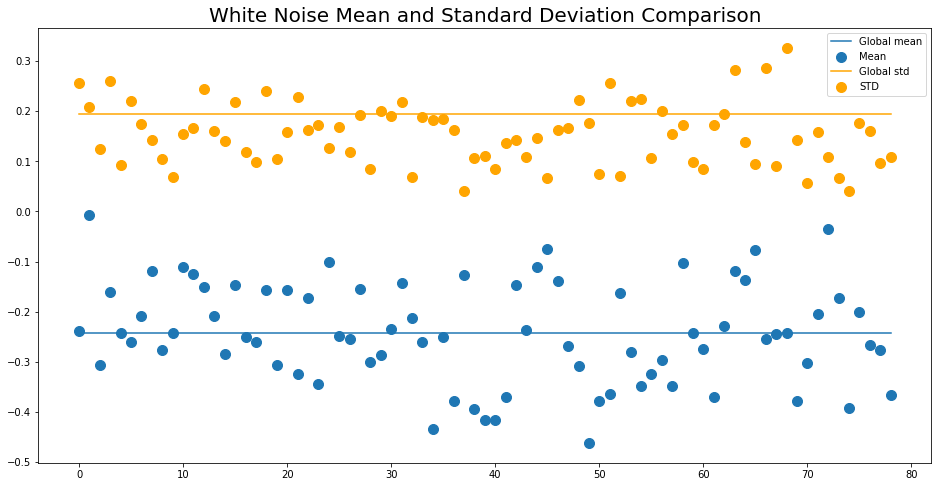

In [15]:
#code snippet from https://towardsdatascience.com/time-series-from-scratch-white-noise-and-random-walk-5c96270514d3
# Split into an arbitraty number of chunks
white_noise_bins = np.split(sentiment_df["compound"], 79) #5 chunks
means, stds = [], []

# Get the mean and std values for every chunk
for chunk in white_noise_bins:
    means.append(np.mean(chunk))
    stds.append(np.std(chunk))
    
    
# Plot
fig = plt.figure(figsize=(16,8))
plt.title('White Noise Mean and Standard Deviation Comparison', size=20)
plt.plot(np.arange(len(means)), [sentiment_df["compound"].mean()] * len(means), label='Global mean', lw=1.5)
plt.scatter(x=np.arange(len(means)), y=means, label='Mean', s=100)
plt.plot(np.arange(len(stds)), [sentiment_df["compound"].std()] * len(stds), label='Global std', lw=1.5, color='orange')
plt.scatter(x=np.arange(len(stds)), y=stds, label='STD', color='orange', s=100)
plt.legend();

Here we can see clearly that our mean value is not zero (even if close), standard deviation attests itself around 0.2.

##### 8.2.2.3 Autocorrelation

Autocorrelation is a mathematical representation of the degree of similarity between a given time series and a lagged version of itself over successive time intervals. [[8]](#references_) Autocorrelation plots also include a shaded area that represents confidence intervals. Anything inside the shaded area means that the correlation at that point isn’t statistically significant. Also the X axis represents the lag, and the Y axis is the Pearson’s correlation coefficient at each lag. Please note that autocorrelation at lag 0 will have a value of 1, since the correlation is calculated between two identical time series. In this case autocorrelation answer the question of: how correlated are the news sentiment compound values compared to the previous period. Generally when seasonality exists, the autocorrelation goes up periodically at larger lags.[[9]](#references_)

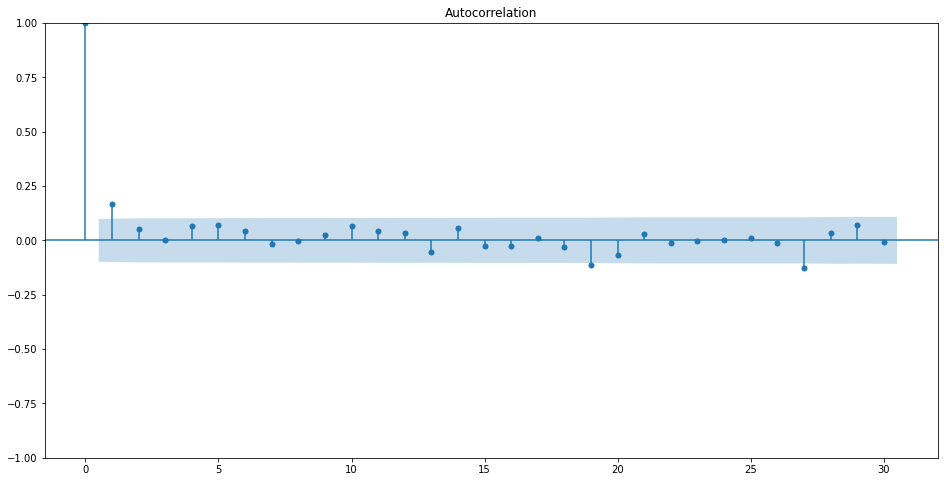

In [16]:

plot_acf(np.array(sentiment_df["compound"]), lags=30); #period of 1 month


Most of the lags are within the confidence interval, while only 3 are slightly out of it. I can conclude that we are not dealing with a random walk and neither with white noise even if we have many of the characteristics of this one.

### 8.3 Decomposition of Time Series

Finally we can have a better picture of the characteristics of the time series by analyzing the trend, seasonability and noise. With these terms we ask ourselves:

* Seasonality: does the data has a clear periodic pattern?
* Trend - does the data presents an important slope
* Noise - are there outliers that are not consistent with our data?

In [17]:
sentiment_df.index = pd.to_datetime(sentiment_df.index) #setting the index as datetime

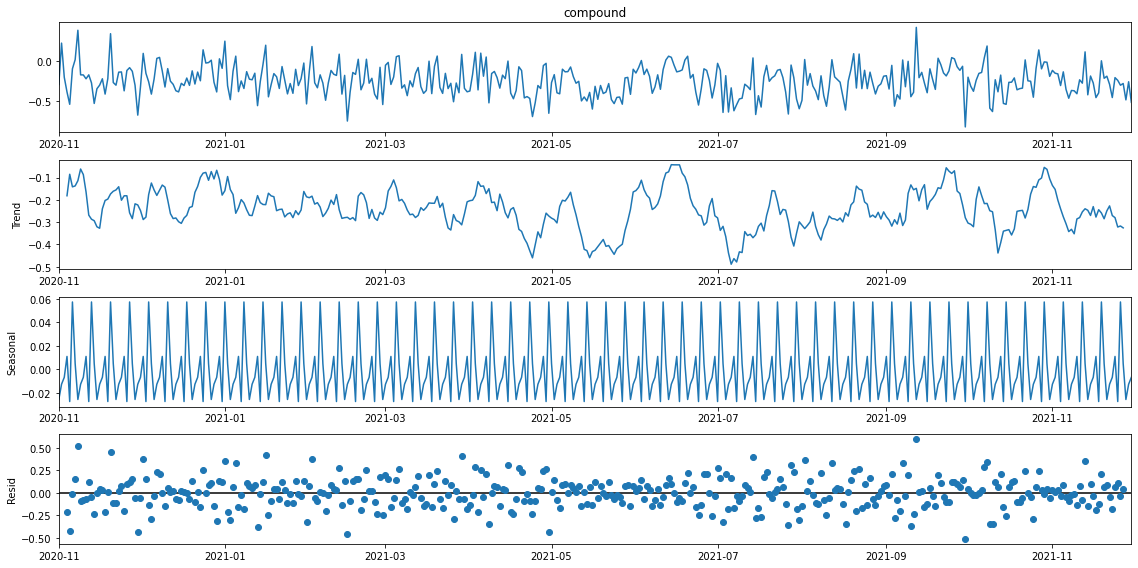

In [18]:

# Additive Decomposition

result_add = seasonal_decompose(sentiment_df["compound"], model='additive') #The term additive means individual components (trend, seasonality, and residual) are added together
result_add.plot();


From this graph we can tell that there's not any strong trend in any direction, seasonability is very noisy and the residual graph doesn't show any strong inconsistency with the data.
We conclude that there's not that much that can be inferred using the compound sentiment value solely.

### 8.4 Forecasting Covid?

Now, what about if we add the day frequency of Covid related topics as a new feature and try to understand if there's a trend with the actual virus spread and if there's any correlation between the good and the bad news with covid? Let me try to answer this question:

#### 8.4.1 Covid trend analysis

In [19]:
#creating a new Covid feature and aggregating all COVID related words
df["coronavirus"] = df["corpuses"].str.contains("coronav|vaccin|quarant|virus|pandem",case=False, regex=True).astype(int)

#creating new dataframe
covid_df = df[["coronavirus", "compound", "negative", "positive"]]

# grouping by different aggregate functions
covid_df = covid_df.groupby(df.index.date).agg({
    "coronavirus": np.sum,
    "compound": np.mean,
    "negative": np.mean,
    "positive": np.mean
})

<AxesSubplot:>

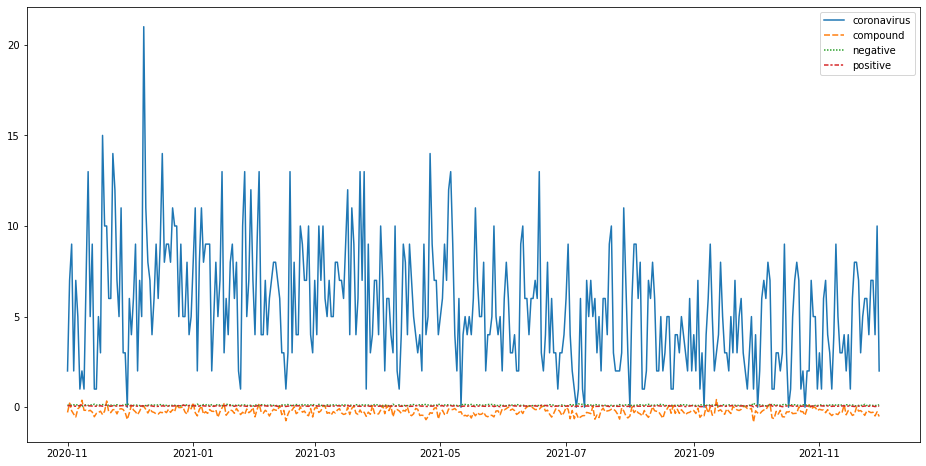

In [20]:
sns.lineplot(data=covid_df)

As we can see, the covid feature is on a different scale compared to the sentiment features, we will take care of this later performing scaling of the features. Now let's focus our attention on the newly created covid feature and analyze it. To smooth out our findings we will use the rolling average feature, where we can describe a rolling average as follow:

>Rolling averages, also known as moving averages, are a type of chart analysis technique used to examine survey data collected over extended periods of time, for example, in political tracking polls. They are typically utilized to smooth out data series. The ultimate purpose of rolling averages is to identify long—term trends. They are calculated by averaging a group of observations of a variable of interest over a specific period of time. Such averaged number becomes representative of that period in a trend line. It is said that these period-based averages "roll," or "move," because when a new observation is gathered over time, the oldest observation of the pool being averaged is dropped out and the most recent observation is included into the average. [[10]](#references_)

Basically, time series data in original format can be quite volatile, especially on smaller aggregation levels. The concept of rolling, or moving averages is a useful technique for smoothing time series data. [[11]](#references_)

Text(0.5, 1.0, 'Coronavirus related news frequency - 30 days rolling mean')

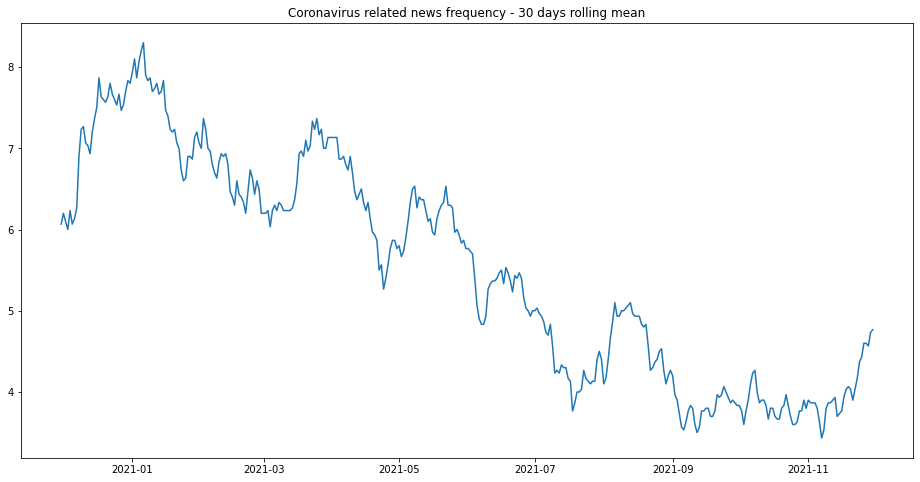

In [21]:
covid_df["coronavirus"].rolling(30).mean().plot() #rolling window of 30 days
plt.title("Coronavirus related news frequency - 30 days rolling mean")

We can see that there's a clear trend and somewhat a monthly seasonability. As we said before, the trend component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance. [[12]](#references_)

We will use the statsmodel - deterministic process module: this is specifically indicated to perform time series analysis. In particular we can affirm that a deterministic process is a technical term for a time series that is non-random or completely determined like the const and trend series are. Features derived from the time index will generally be deterministic. [[12]](#references_)

In [22]:
# code snippet from https://www.kaggle.com/ryanholbrook/trend
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=covid_df.index,  # dates from the data
    constant=True,       # dummy feature for the bias
    order=3,             # the time dummy (trend) - we'll use the polynomial order of 3
    drop=True,           # drop terms if necessary to avoid collinearity
)

# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()
X.head()



const  trend  trend_squared  trend_cubed
2020-11-01    1.0    1.0            1.0          1.0
2020-11-02    1.0    2.0            4.0          8.0
2020-11-03    1.0    3.0            9.0         27.0
2020-11-04    1.0    4.0           16.0         64.0
2020-11-05    1.0    5.0           25.0        125.0

We will use Linear Regression to fit our data on:

In [23]:
from sklearn.linear_model import LinearRegression

y = covid_df["coronavirus"]  # the target

model = LinearRegression(fit_intercept=False) #LinearRegression behaves badly with duplicated features [12]
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

<AxesSubplot:title={'center':'Covid Trend Over 1 Year'}>

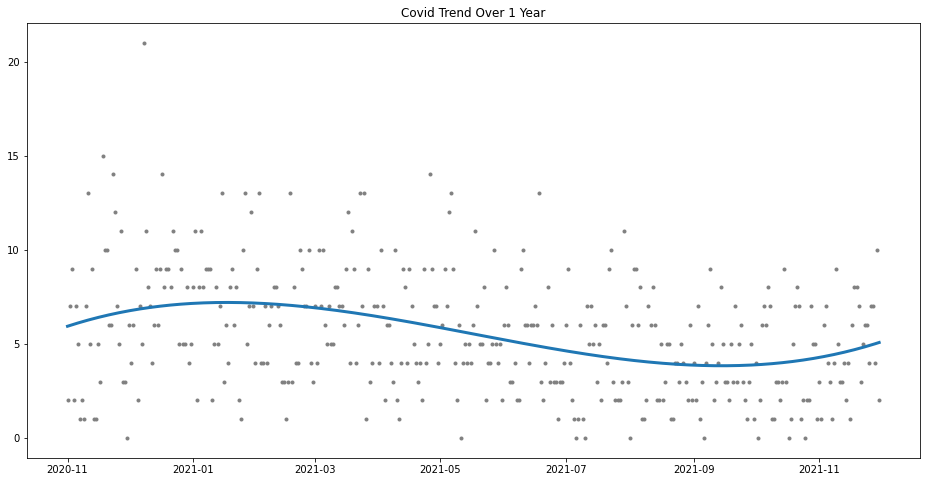

In [24]:
ax = covid_df["coronavirus"].plot(style=".", color="0.5", title="Covid Trend Over 1 Year")
y_pred.plot(ax=ax, linewidth=3, label="Trend")

To make a forecast, we apply our model to "out of sample" features. "Out of sample" refers to times outside of the observation period of the training data. Here's how we could make a 30-day forecast:

In [25]:
X = dp.out_of_sample(steps=30) #creating the out of sample

base = datetime.datetime(2021,12,1) #creating base time

date_list = [base+datetime.timedelta(days=x) for x in range(30)] # index dates for the forecast

y_fore = pd.Series(model.predict(X), index=date_list) #forecast


In [26]:
#changing the indexes to datetime
covid_df.index = pd.to_datetime(covid_df.index)
y_pred.index= pd.to_datetime(y_pred.index)

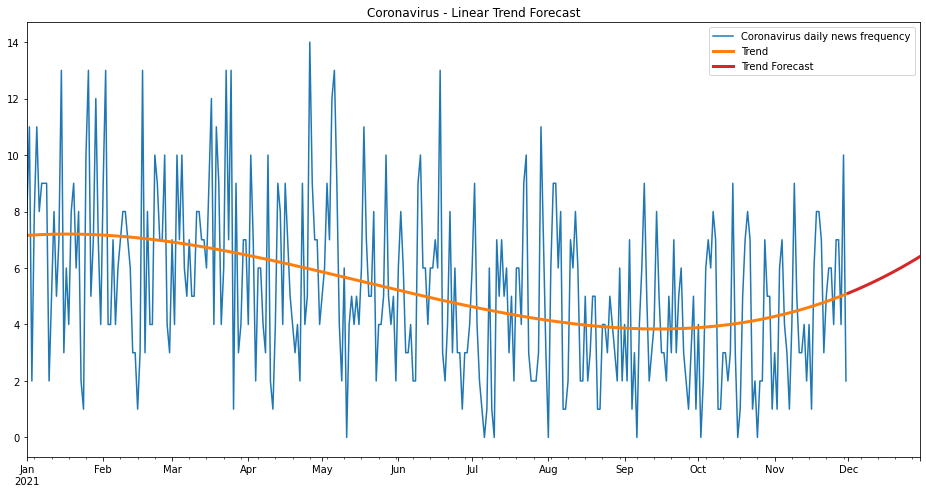

In [27]:
#plot
ax = covid_df["2021-1-1":]["coronavirus"].plot(title="Coronavirus - Linear Trend Forecast", label="Coronavirus daily news frequency")
ax = y_pred["2021-1-1":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
ax.legend()

As we can see, we have a strong upwards trend by the end of November. Considering that this study's data remained unchanged since part 1, and that we are now seeing this "from the future", we can confirm that indeed there has been a strong raise in Covid cases around the world due to the Omicron variant.

#### 8.4.2 Covid news correlation with sentiment features

Let's check now the correlation of the Covid feature with the sentiment scores. We will first scale our features so that we can make them comparable:

In [28]:
scaler = MinMaxScaler() #scaling the features

covid_df_scaled = pd.DataFrame(scaler.fit_transform(covid_df), columns=covid_df.columns, index=covid_df.index)

covid_df_scaled

coronavirus  compound  negative  positive
2020-11-01     0.095238  0.426644  0.470776  0.383094
2020-11-02     0.333333  0.841879  0.170610  0.489536
2020-11-03     0.428571  0.498824  0.429849  0.370252
2020-11-04     0.095238  0.351188  0.448833  0.346583
2020-11-05     0.333333  0.227181  0.528330  0.254928
...                 ...       ...       ...       ...
2021-11-26     0.333333  0.418933  0.378615  0.438804
2021-11-27     0.333333  0.436235  0.256470  0.288225
2021-11-28     0.190476  0.271844  0.256897  0.125719
2021-11-29     0.476190  0.453807  0.220030  0.268393
2021-11-30     0.095238  0.247288  0.483771  0.253646

[395 rows x 4 columns]

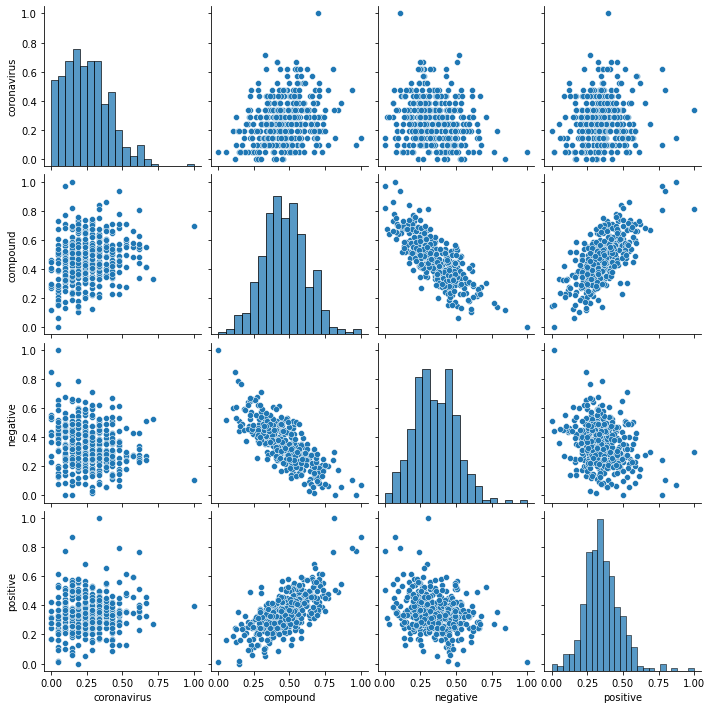

In [29]:
sns.pairplot(data=covid_df_scaled)

As we can see there's no clear correlation between the covid feature and any kind of sentiment score, to have a clearer view let's plot the heatmap with the pearson correlation value:

<AxesSubplot:>

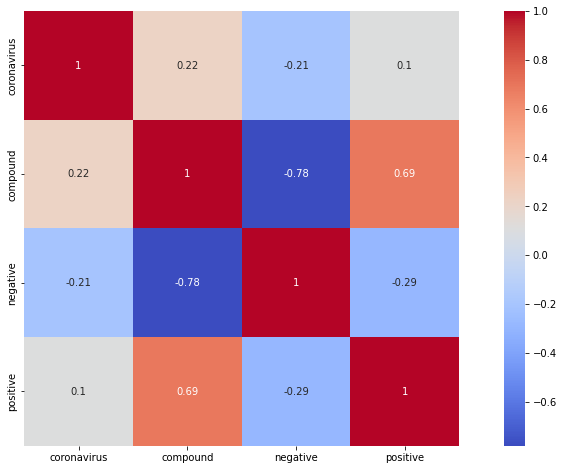

In [30]:
sns.heatmap(covid_df_scaled.corr(method="pearson"), annot=True, cmap="coolwarm", square=True)

We have a slight correlation with the compound and negative value but not comparable with the scale of the (obvious) correlation between the sentiment scores.

## 9 Analyzing Sentiment Scores

Our analysis will rely mostly on the VADER model. VADER ( Valence Aware Dictionary for Sentiment Reasoning) is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. [[13]](#reference_) It is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. [[14]](#reference_)

We will also try to confront its scores to some other pretrained models and see how the training text and the algorithm behind the scorer can affect the results.

### 9.1 Creating a new sentiment feature

Let's create a new sentiment score feature based on another pretrained model. We will perform an analysis of the scoring time as well and decide which one could be best for our scope.

#### 9.1.1 Twitter-roBERTa-base for Sentiment Analysis

This is a roBERTa-base model trained on ~58M tweets and finetuned for sentiment analysis with the TweetEval benchmark. It has 3 labels: 0 -> Negative; 1 -> Neutral; 2 -> Positive [[15]](#references_)

In [31]:
#Rroberta
roberta_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
roberta = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

In [32]:
#example
tokens = roberta_tokenizer.encode("Hello, my dog is cute", return_tensors="pt")
result = roberta(tokens)
result.logits #The highest score determine the position of the label

In [34]:
score = int(torch.argmax(result.logits)) #finding the position of the highest score with argmax
score

2

In this case the highest score is in position 2 (and thus positive) as confirmed by our code

In [35]:
def roberta_sentiment(text):
    """Sentiment analysis using the Roberta pretrained model
    labels: 0 -> Negative; 1 -> Neutral; 2 -> Positive

    Args:
        text (str): text to analyze

    Returns:
        ndarray: score labels: negative, neutral and positive. 
    """
    tokens = roberta_tokenizer.encode(text, return_tensors="pt")
    result = roberta(tokens)
    return int(torch.argmax(result.logits))
    

In [36]:
start_time = datetime.datetime.now()
df["corpuses"][:30].apply(roberta_sentiment)
end_time_roberta = (datetime.datetime.now() - start_time).seconds
print(f"--- {end_time_roberta} seconds ---")

--- 12 seconds ---


#### 9.1.2 DistilBERT base uncased finetuned SST-2

This model is a fine-tune checkpoint of DistilBERT-base-uncased, fine-tuned on SST-2. This model reaches an accuracy of 91.3 on the dev set (for comparison, Bert bert-base-uncased version reaches an accuracy of 92.7).[[16]](#references_)

In [37]:
#distilbert-base-uncased-finetuned-sst-2-english

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classi

In [38]:
#example

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits
logits[0] # the highest value is the label in his case positive

tensor([0.0650, 0.0967], grad_fn=<SelectBackward0>)

In [39]:
def distilbert_sentiment(text):
    """Distilbert sentiment analysis
    labels: 1 -> Negative; 2 -> Positive

    Args:
        text (str): text to analyse

    Returns:
        tensor: sentiment negative and positive score.
    """
    inputs = tokenizer(text, return_tensors="pt")
    labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
    outputs = model(**inputs, labels=labels)
    return int(torch.argmax(outputs.logits[0]))+1
    

In [40]:
start_time=datetime.datetime.now()
df["corpuses"][:30].apply(distilbert_sentiment)
end_time_disbert = (datetime.datetime.now() - start_time).seconds
print(f"--- {end_time_disbert} seconds ---")

--- 6 seconds ---


#### 9.1.3 bert-base-multilingual-uncased-sentiment

This a bert-base-multilingual-uncased model finetuned for sentiment analysis on product reviews in six languages: English, Dutch, German, French, Spanish and Italian. It predicts the sentiment of the review as a number of stars (between 1 and 5).

This model is intended for direct use as a sentiment analysis model for product reviews in any of the six languages above, or for further finetuning on related sentiment analysis tasks. [[17]](#references_)

In [41]:
#bert

bert_tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
bert = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

In [42]:
#example

tokens = bert_tokenizer.encode("Hello, my dog is cute", return_tensors="pt")
result = bert(tokens)
result.logits

tensor([[-1.6257, -1.5413,  0.0138,  0.9952,  1.7027]],
       grad_fn=<AddmmBackward0>)

In [43]:
#bert_sentiment
#let's create a function
def bert_sentiment(text):
    """Bert sentiment analyzer

    Args:
        text (str): text to be analysed

    Returns:
        int: Sentiment score based on a 1 to 5 score
    """
    tokens = bert_tokenizer.encode(text, return_tensors="pt")
    result = bert(tokens)
    return int(torch.argmax(result.logits))+1


In [44]:

start_time = datetime.datetime.now()
df["corpuses"][:30].apply(bert_sentiment)
end_time_bert = (datetime.datetime.now() - start_time).seconds
print(f"--- {end_time_bert} seconds ---")

--- 13 seconds ---


#### 9.1.4 Text Blob

TextBlob is a Python (2 and 3) library for processing textual data. It provides a consistent API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, and more. [[18]](#references_)

In [45]:
#textblob
start_time = datetime.datetime.now()
df["corpuses"][:30].apply(lambda x: TextBlob(x).sentiment)
end_time_blob = (datetime.datetime.now() - start_time).seconds
print(f"--- {end_time_blob} seconds ---")
#even with 100 had 0 secs

--- 0 seconds ---


Let's visualize each process time and base our decision on this value. Obviously an accuracy based choice would be best but for the purpose of this study we will stick with fastness of time evaluation.

In [46]:
data={
    "end time": [end_time_roberta, end_time_bert, end_time_blob, end_time_disbert]
}

<AxesSubplot:title={'center':'Sentiment Models processing time for 30 entries'}, ylabel='seconds'>

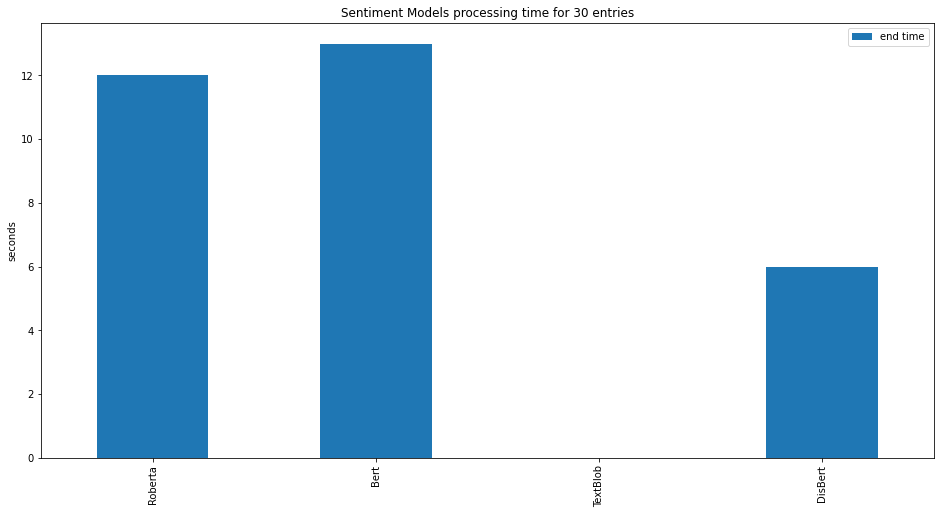

In [47]:
pd.DataFrame(data=data, index=["Roberta", "Bert", "TextBlob", "DisBert"]).plot.bar(ylabel="seconds", title="Sentiment Models processing time for 30 entries")

As we can see, Text Blob is the fastest and it is roughly one order faster than other models. We will then use Text Blob for our new sentiment feature. (Depending on the machine the second fastest model, DistilBert, would have taken around 20 min)

In [48]:
df["text_blob_sentiment"]=df["corpuses"].apply(lambda x: TextBlob(x).sentiment[0])

### 9.2 Keywords sentiment score

Our first considerations will be on the most used keywords sentiment negative and positive scores to understand which topic had the most positive or negative score. To do so we will bin our scores in 3 categories:

In [49]:
def compound_bin(compound_value):
    """This function bin the compound score in 3 categories:
    score > 0 Positive
    score < 0 Negative
    score = 0 Neutral

    Args:
        compound_value (int): sentiment score

    Returns:
        int: binned sentiment score
    """
    if compound_value>0:
        return "pos"
    elif compound_value==0:
        return "neu"
    return "neg"

df["compound_bin"] = df["compound"].apply(compound_bin) #binning in -1, 0, 1
df["compound_bin_blob"] = df["text_blob_sentiment"].apply(compound_bin) #binning in -1, 0, 1

We need to transform the keywords column from str to list and then extract the sentiment value from each keyword

In [50]:
df["keywords"] = df["keywords"].apply(literal_eval) #transforming from string to list

In [51]:
df_exploded = df.explode("keywords") #exploding the keyword column in one single keyword per cell
df_exploded.reset_index(inplace=True)
df_exploded["keywords"].head(10)

0                              Politics and Government
1    United Nations Framework Convention on Climate...
2                             Greenhouse Gas Emissions
3                                       Global Warming
4                                                 Coal
5                                           Wind Power
6                     Alternative and Renewable Energy
7                          Electricite de France (EDF)
8                                       United Nations
9                                       Johnson, Boris
Name: keywords, dtype: object

In [93]:
#creating the dataframe with the count of each score per keyword
#vader
order_vader = pd.crosstab(df_exploded["keywords"], df_exploded.compound_bin)
order_vader["total news"] = order_vader.apply(sum, axis=1) #creating sum of articles per each keyword
order_vader.rename(columns={"neg":"negative", "neu":"neutral", "pos":"positive"}, inplace=True)

#textblob
order_blob = pd.crosstab(df_exploded["keywords"], df_exploded.compound_bin_blob)
# order_blob["total news"] = order_blob.apply(sum, axis=1)
order_blob.rename(columns={"neg":"negative", "neu":"neutral", "pos":"positive"}, inplace=True)

In [94]:
order_vader.head()

compound_bin                         negative  neutral  positive  total news
keywords                                                                    
#MeToo Movement                            35        0         1          36
'Ndrangheta                                 2        0         0           2
1Malaysia Development Berhad (1MDB)         1        0         0           1
400 Mawozo (Gang)                           7        1         2          10
5G (Wireless Communications)                0        0         1           1

We will visualize the most used keyword respectively with Vader and TextBlob to try to spot any difference in the score assignment. Also we wil plot together the total news per each keyword to visualize and understand the weight of the keyword in the NYT news

In [95]:
vader_blob_scores=pd.concat([order_vader, order_blob], axis=1, keys=("vader", "blob"))
vader_blob_scores.columns.names=["Model", "Sentiment"]

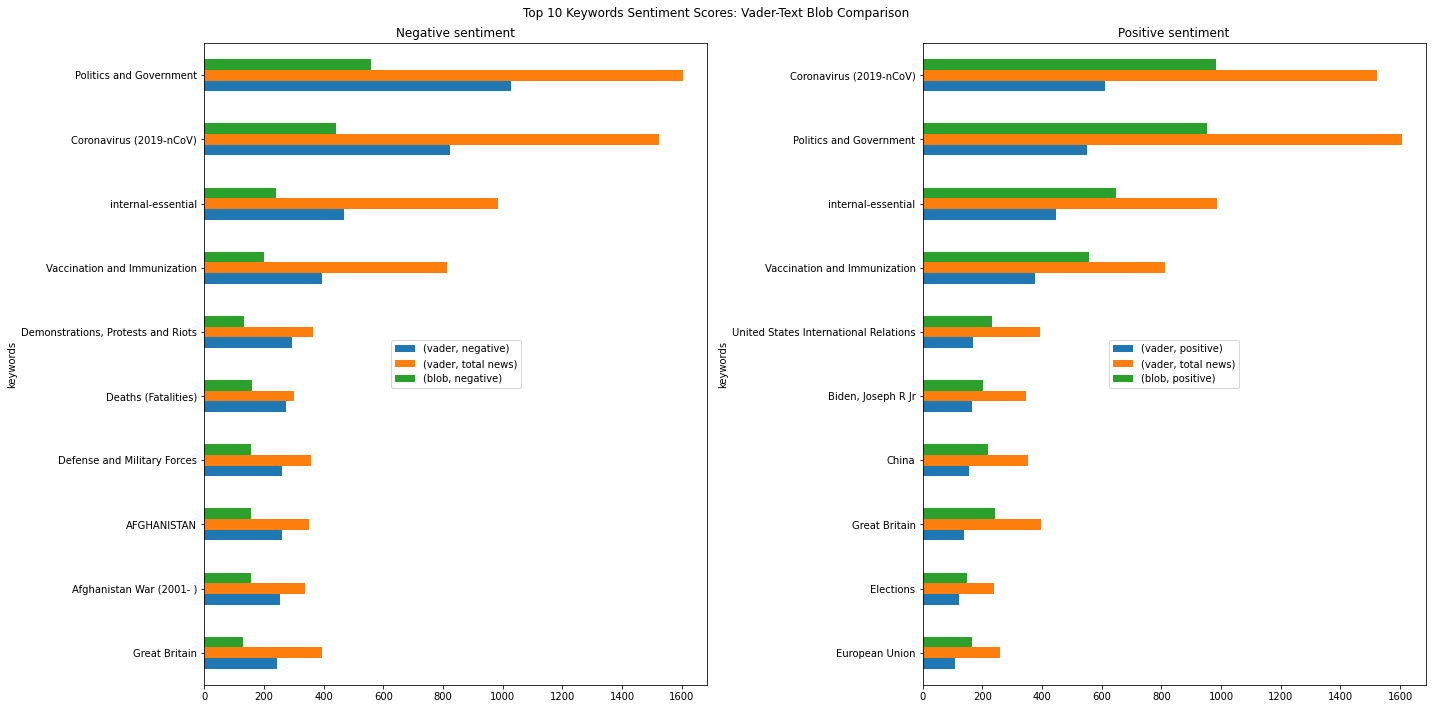

In [118]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(20,10))

vader_blob_scores.sort_values(by=[("vader", "negative")], ascending=True).loc[:, (slice(None), ['negative', "total news"])][-10:].plot.barh(ax=ax1)
ax1.legend(loc="center")
ax1.set_title("Negative sentiment")
vader_blob_scores.sort_values(by=[("vader", "positive")], ascending=True).loc[:, (slice(None), ['positive', "total news"])][-10:].plot.barh(ax=ax2)
ax2.legend(loc="center")
ax2.set_title("Positive sentiment")

plt.suptitle("Top 10 Keywords Sentiment Scores: Vader-Text Blob Comparison")
plt.tight_layout()


As we can see from this chart, it looks like Text Blob tends to give a more positive scores to to the same topics while Vader tends to be more negative (as we saw before indeed the mean value of Vader is negative). This chart has been ordered according to Vader scoring, let's investigate further the the difference between model in text scoring.

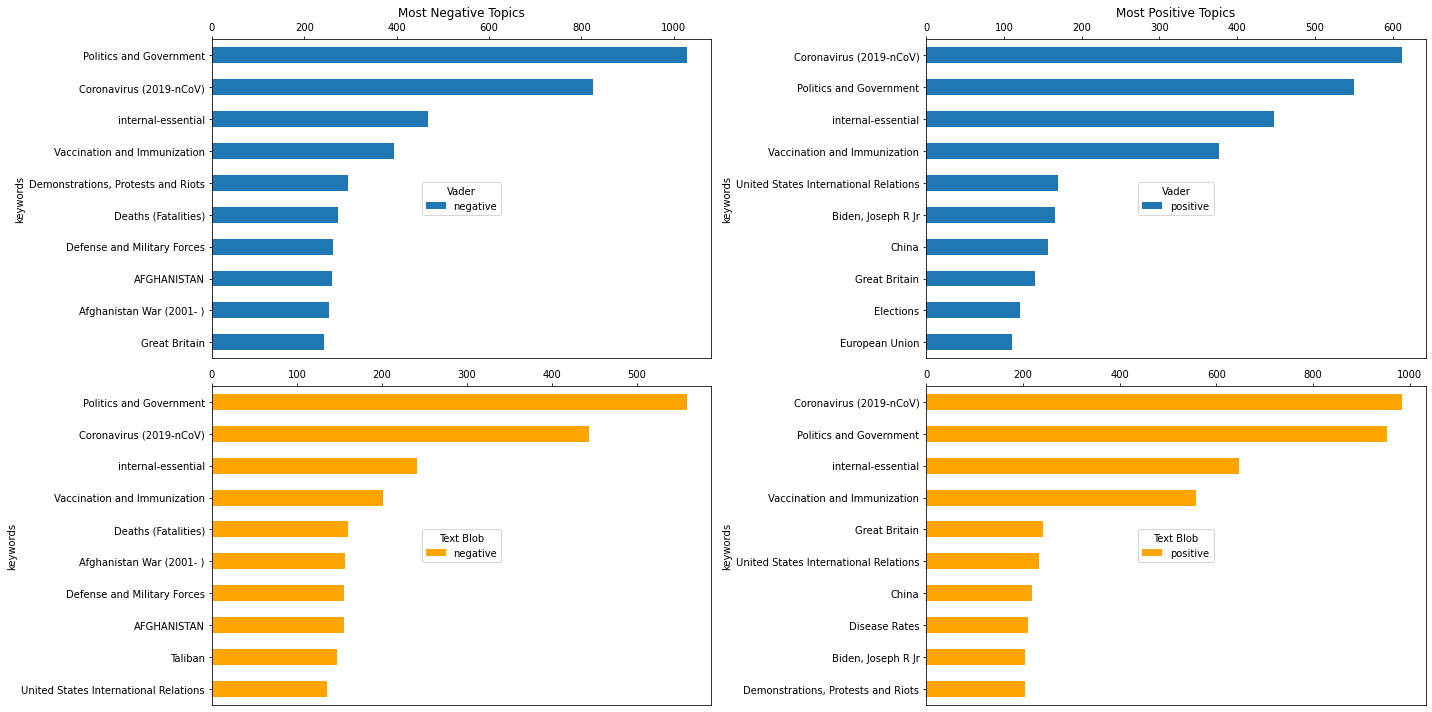

In [123]:
fig, ax= plt.subplots(nrows=2, ncols=2,figsize=(20,10))

#Negative Topics
order_vader.sort_values(by="negative", ascending=True)["negative"][-10:].plot.barh(ax=ax[0,0])
ax[0,0].set_title("Most Negative Topics")
ax[0,0].xaxis.tick_top()
ax[0,0].xaxis.set_label_position('top')
ax[0,0].legend(title="Vader", loc="center")
#Negative Topics
order_blob.sort_values(by="negative", ascending=True)["negative"][-10:].plot.barh(ax=ax[1,0], color="orange")
ax[1,0].xaxis.tick_top()
ax[1,0].xaxis.set_label_position('top')
ax[1,0].legend(title="Text Blob", loc="center")

order_vader.sort_values(by="positive", ascending=True)["positive"][-10:].plot.barh(ax=ax[0,1])
ax[0,1].set_title("Most Positive Topics")
ax[0,1].xaxis.tick_top()
ax[0,1].xaxis.set_label_position('top')
ax[0,1].legend(title="Vader", loc="center")

order_blob.sort_values(by="positive", ascending=True)["positive"][-10:].plot.barh(ax=ax[1,1],color="orange" )
ax[1,1].xaxis.tick_top()
ax[1,1].xaxis.set_label_position('top')
ax[1,1].legend(title="Text Blob", loc="center")

plt.tight_layout()

Both negative and positive scores for Vader and Text Blob have the same keywords in the first 4 positions for both models. Things start to change after them: for example in the Text Blob scoring U.K. is tree position ahead among the most positive topics compared to Vader but oddly it shows Demonstrations, Protests and Riots between positive topics.

### 9.3 Daily Good and Bad news

Let's have a deeper look now at the sentiment scores. We will analyze them on a daily basis first and then based on the correspondent geographical subsection.

In [127]:
heat = df.pivot_table(index=[df.index.day,df.index.month], values=["compound", "text_blob_sentiment"], aggfunc="mean").unstack() #creating day vs months table per each model
heat.index.names = ["Day"]
heat.columns.names = ["", "Month"]

In [128]:
heat.head(3)

compound                                                              \
Month        1         2         3         4         5         6         7    
Day                                                                           
1      0.248085 -0.132316 -0.051743 -0.372208 -0.267173 -0.148544 -0.028200   
2     -0.307406  0.181171 -0.016627 -0.165242 -0.168825 -0.080741 -0.116495   
3     -0.479813 -0.270347 -0.290821  0.109519 -0.394818  0.007147 -0.639057   

                                     ... text_blob_sentiment            \
Month        8         9         10  ...                  3         4    
Day                                  ...                                 
1     -0.488500 -0.181958 -0.200570  ...            0.056133  0.121698   
2      0.019257 -0.347700 -0.312978  ...            0.086204  0.040508   
3     -0.299922 -0.053306 -0.375827  ...            0.048834  0.088222   

                                                                             \
Month        5         6         7         8         9         10        11   
Day                                                                           
1     -0.027237  0.032100  0.068887  0.026053  0.065500  0.011986  0.084119   
2      0.081515  0.045304  0.072631  0.151713  0.009414 -0.041836  0.083836   
3      0.005205  0.069260 -0.018306  0.031506  0.041145  0.044167  0.066539   

                 
Month        12  
Day              
1      0.051385  
2      0.143602  
3      0.052291  

[3 rows x 24 columns]

Let' plot a map of the days of the month against the months to understand what have been the best and the worst days according to the sentiment score:

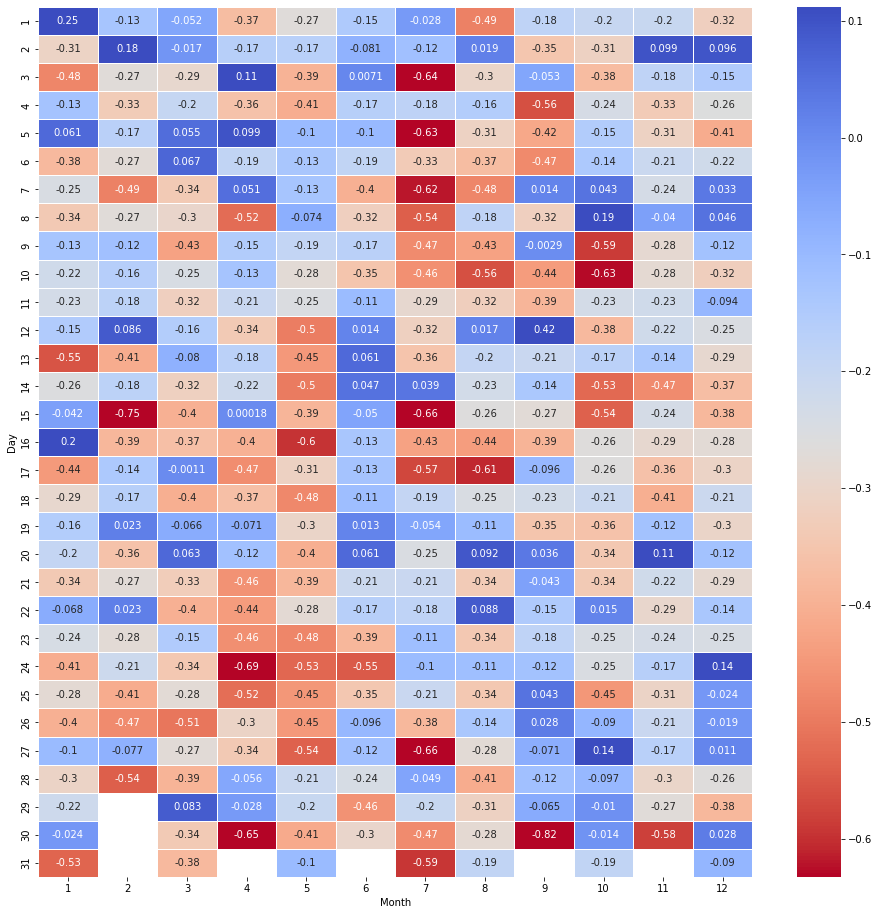

In [129]:
fig, ax = plt.subplots(figsize=(16,16))

ax = sns.heatmap(heat["compound"], cmap="coolwarm_r", annot=True, robust=True, linewidths=.5)

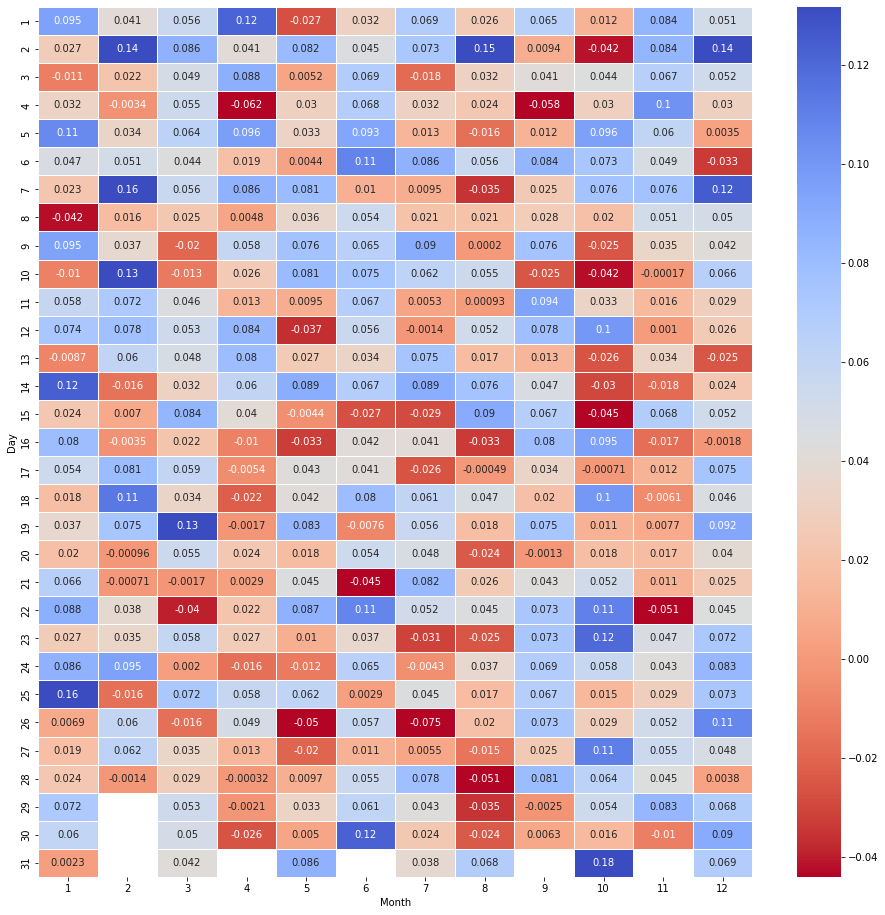

In [130]:
fig, ax = plt.subplots(figsize=(16,16))

ax = sns.heatmap(heat["text_blob_sentiment"], cmap="coolwarm_r", annot=True, robust=True, linewidths=.5)

The scores in the heatmap refer to the mean sentiment per day. Let's try to place on the time series what the 3 worst and best news were in these days and if their scores actually adhere to the real negativeness or positiveness of the news.

In [131]:
text_blob_day_mean = df.groupby(df.index)["text_blob_sentiment"].mean() #adding the text blob feature to the sentiments score df
sentiment_df = sentiment_df.merge(text_blob_day_mean, how="inner", on=sentiment_df.index).set_index("key_0")
sentiment_df.index.names = ["date"]

In [132]:
sentiment_df["compound"].sort_values()[:3] #worst days for VADER

date
2021-09-30   -0.819625
2021-02-15   -0.746620
2021-04-24   -0.690700
Name: compound, dtype: float64

In [133]:
print(df.loc["2021-09-30", ["headline","compound"]].sort_values(by="compound")["headline"].values[0])
print(df.loc["2021-02-15", ["headline","compound"]].sort_values(by="compound")["headline"].values[0])
print(df.loc["2021-04-24", ["headline","compound"]].sort_values(by="compound")["headline"].values[0])

Police Officer Sentenced to Life in Prison for Murder of Sarah Everard
Zuma Risks Arrest After Defying South Africa Corruption Inquiry
Terrorism Fears Feed the Rise of France’s Extreme Right


In [134]:
sentiment_df["text_blob_sentiment"].sort_values()[:3] #worst days for TextBlob

date
2020-11-22   -0.119235
2021-11-14   -0.078672
2021-07-26   -0.074726
Name: text_blob_sentiment, dtype: float64

In [135]:
print(df.loc["2020-11-22", ["headline","text_blob_sentiment"]].sort_values(by="text_blob_sentiment")["headline"].values[0])
print(df.loc["2021-11-14", ["headline","text_blob_sentiment"]].sort_values(by="text_blob_sentiment")["headline"].values[0])
print(df.loc["2021-07-26", ["headline","text_blob_sentiment"]].sort_values(by="text_blob_sentiment")["headline"].values[0])

Protesters in Guatemala Set Fire to Congress Building Over Spending Cuts
A video of decontamination workers clubbing a pet corgi stirs anger in China.
Scores Die in India as Monsoon Rains Swamp Towns and Send Boulders Tumbling


In [136]:
sentiment_df["compound"].sort_values(ascending=False)[:3] #best days VADER

date
2021-09-12    0.419700
2020-11-08    0.383930
2020-11-20    0.340975
Name: compound, dtype: float64

In [137]:
print(df.loc["2021-09-12", ["headline","compound"]].sort_values(by="compound", ascending=False)["headline"].values[0])
print(df.loc["2021-02-15", ["headline","compound"]].sort_values(by="compound", ascending=False)["headline"].values[0])
print(df.loc["2021-04-24", ["headline","compound"]].sort_values(by="compound", ascending=False)["headline"].values[0])

A New Sports Star Showcases the Diversity of a More Complex Britain
N.Y.C.’s subway system will start running longer into the night next week, officials say.
Debris From Indonesian Submarine Is Found, Ending Hopes of Rescue


In [138]:
sentiment_df["text_blob_sentiment"].sort_values(ascending=False)[:3] #best days for TextBlob

date
2021-10-31    0.175332
2021-02-07    0.160471
2021-01-25    0.158815
Name: text_blob_sentiment, dtype: float64

In [139]:
print(df.loc["2021-10-31", ["headline","text_blob_sentiment"]].sort_values(by="text_blob_sentiment")["headline"].values[0])
print(df.loc["2021-02-07", ["headline","text_blob_sentiment"]].sort_values(by="text_blob_sentiment")["headline"].values[0])
print(df.loc["2021-01-25", ["headline","text_blob_sentiment"]].sort_values(by="text_blob_sentiment")["headline"].values[0])

Storms Cause Deadly Floods in Sicily
Protests Against Military Takeover Spread Across Myanmar
In Poor Madrid Neighborhood, Biggest Snowfall in Half Century Deepens Misery


In [140]:
peak_days_vader = [
    #worst days
    (datetime.datetime(2021, 9, 30), "Police Officer Sentenced to Life in Prison for Murder of Sarah Everard"),
    (datetime.datetime(2021, 2, 15), "Zuma Risks Arrest After Defying South Africa Corruption Inquiry"),
    (datetime.datetime(2021, 4, 24), "Terrorism Fears Feed the Rise of France’s Extreme Right"),
    #best days
    (datetime.datetime(2021, 9, 12), "A New Sports Star Showcases the Diversity of a More Complex Britain"),
    (datetime.datetime(2020, 11, 8), "N.Y.C.’s subway system will start running longer into the night next week, officials say."),
    (datetime.datetime(2020, 11, 20), "Debris From Indonesian Submarine Is Found, Ending Hopes of Rescue")
]

In [141]:

peak_days_text_blob = [
    #worst days
    (datetime.datetime(2020, 11, 22), "Protesters in Guatemala Set Fire to Congress Building Over Spending Cutsn"),
    (datetime.datetime(2021, 11, 14), "A video of decontamination workers clubbing a pet corgi stirs anger in China."),
    (datetime.datetime(2021, 7, 26), "Scores Die in India \n as Monsoon Rains Swamp Towns and Send Boulders Tumbling"),
    #best days
    (datetime.datetime(2021, 10, 31), "Storms Cause Deadly Floods in Sicily"),
    (datetime.datetime(2021, 2, 7), "Protests Against Military Takeover Spread Across Myanmar"),
    (datetime.datetime(2021, 1, 25), "In Poor Madrid Neighborhood, Biggest Snowfall in Half Century Deepens Misery")
]

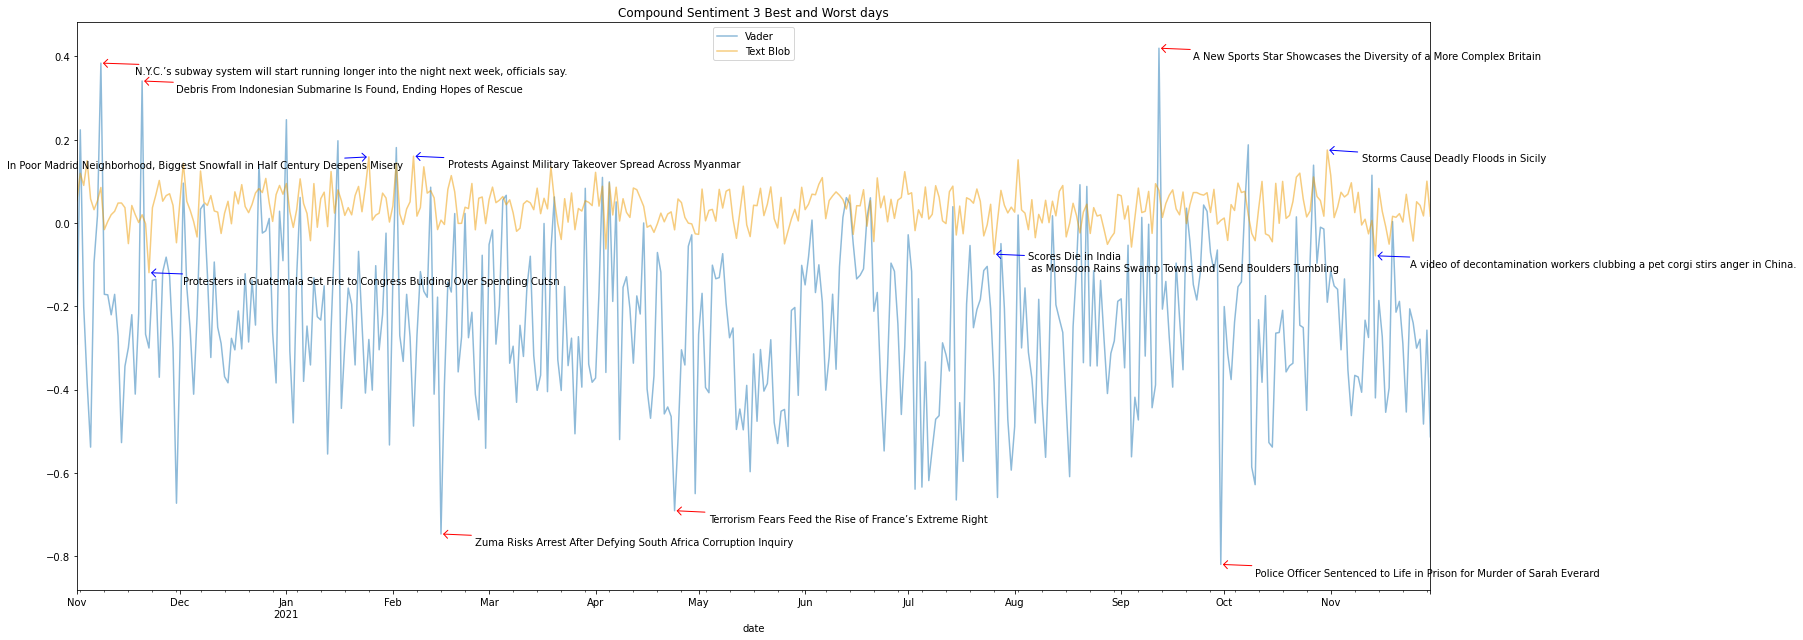

In [146]:
fig, ax = plt.subplots(figsize=(25,9))

comp = sentiment_df["compound"]
comp.plot(ax=ax, alpha=0.5, label="Vader")

blob=sentiment_df["text_blob_sentiment"]
blob.plot(ax=ax, color="#ee9b00", alpha=0.5, label="Text Blob")

for date, label in peak_days_vader:
    ax.annotate(label, xy=(date, comp.asof(date)),
                xycoords='data',
                xytext=(date+datetime.timedelta(10), comp.asof(date)-0.02),
                arrowprops=dict(facecolor='red',arrowstyle="->,head_width=.4", color="red"),
                horizontalalignment="left", verticalalignment="center"
                )
    
for date, label in peak_days_text_blob:
    if date != datetime.datetime(2021, 1, 25):
        ax.annotate(label, xy=(date, blob.asof(date)),
                xycoords='data',
                xytext=(date+datetime.timedelta(10), blob.asof(date)-0.02),
                arrowprops=dict(facecolor='blue',arrowstyle="->,head_width=.4", color="blue"),
                horizontalalignment="left", verticalalignment="center"
                )
    else:
        ax.annotate(label, xy=(date, blob.asof(date)),
        xycoords='data',
        xytext=(date+datetime.timedelta(10), blob.asof(date)-0.02),
        arrowprops=dict(facecolor='blue',arrowstyle="->,head_width=.4", color="blue"),
        horizontalalignment="right", verticalalignment="center"
        )
        
    
ax.set_title("Compound Sentiment 3 Best and Worst days")

plt.legend(loc="upper center")

plt.tight_layout()
    

As we can see Text Blob score have much less variability. Also its mean is shifted towards positive values while Vader towards negative ones. 
* Speaking about Vader scores bad news can be considered being labeled right, even if the level of negativeness is subjective. As for the good news, we can say that only 2 out of three have been labeled correctly being the finding of the Indonesian submarine a negative news. This is because perhaps "Hopes" and "Rescue" are labeled with a positive score.
* Speaking about Text Blob scores positive results seems to be totally off while negative ones are right. This might indicate that Text Blob is not indicated for news analysis being trained on a movie review corpus.


### 9.3 Geographical sentiment analysis

Let's have a look now at the sentiment scores assigned per each news based on the zone of the world and the distribution of the score across these news.

In [148]:
df['ID'] = range(1, len(df) + 1) #creating an ID feature to perform grouping

df["compound_trunc"] = df.compound.round(1) # Dividing the compound scores into 0.1 buckets
df["text_blob_trunc"] = df.text_blob_sentiment.round(1)

#defining the country list
countries = ['Europe',
 'World',
 'Asia Pacific',
 'Middle East',
 'Americas',
 'Africa',
 'Australia',
 'Canada',
 'U.S.',
]

filtered_countries_df = df[df.subsection_name.isin(countries)] #creating the filtered dataframe

In [149]:
#grouped dataframe
res_vader = (filtered_countries_df.groupby(["compound_trunc","subsection_name"])["ID"]
        .count()
        .reset_index()
        .rename(columns={"ID": "count"})
      )

res_blob = (filtered_countries_df.groupby(["text_blob_trunc","subsection_name"])["ID"]
        .count()
        .reset_index()
        .rename(columns={"ID": "count"})
      )


Let's plot first the distribuition of the scores across the news (filtered by countries/world zones):

In [150]:
hist_vader = alt.Chart(res_vader, title="Vader Scores Distribution").mark_bar(width=15).encode(
    alt.X("compound_trunc:Q", axis=alt.Axis(title="")),
    y=alt.Y('count:Q', axis=alt.Axis(title="Count")),
    color=alt.Color('compound_trunc:Q', scale=alt.Scale(scheme='redyellowgreen')), 
    tooltip=['compound_trunc', 'count']
).properties(width = 450)

hist_vader

alt.Chart(...)

In [152]:
hist_blob = alt.Chart(res_blob, title="Text Blob Scores Distribution").mark_bar(width=15).encode(
    alt.X("text_blob_trunc:Q", axis=alt.Axis(title="")),
    y=alt.Y('count:Q', axis=alt.Axis(title="Count")),
    color=alt.Color('text_blob_trunc:Q', scale=alt.Scale(scheme='redyellowgreen')), 
    tooltip=['text_blob_trunc', 'count']
).properties(width = 450)

hist_blob


alt.Chart(...)

* Vader: As we can see the distribution of the scores is skewed towards the negative scores, having a peak on the 0.9 compound value. This indicates how there is a prevalence of bad news compared to good news (at least for the country news)
* Text Blob: The distribution of the Text Blob scores are more normally shaped, being most of them neutral.

Now let's plot the distribuition of the sentiment score per each country. This plot might give us an insight on how each continet or part of the world "performed" in terms of good and bad news.

In [153]:
stacked_bar_vader = alt.Chart(res_vader, title="Vader Sentiment per World Zone").mark_bar().encode(
    y = alt.X("subsection_name", axis=alt.Axis(title="Countries")),
    x=alt.Y('count:Q', stack='normalize', axis=alt.Axis(title="", labels=False)),
    color=alt.Color('compound_trunc', scale=alt.Scale(scheme='redyellowgreen')), 
    tooltip=['compound_trunc', 'subsection_name', 'count'],
    order=alt.Order(
      # Sort the segments of the bars by this field
      'compound_trunc',
      sort='ascending')
).properties(height = 850)

stacked_bar_vader #VADER MORE POLARIZED

alt.Chart(...)

In [154]:
stacked_bar_blob = alt.Chart(res_blob, title="Text Blob Sentiment per World Zone").mark_bar().encode(
    y = alt.X("subsection_name", axis=alt.Axis(title="Countries")),
    x=alt.Y('count:Q', stack='normalize', axis=alt.Axis(title="", labels=False)),
    color=alt.Color('text_blob_trunc', scale=alt.Scale(scheme='redyellowgreen')), 
    tooltip=['text_blob_trunc', 'subsection_name', 'count'],
    order=alt.Order(
      # Sort the segments of the bars by this field
      'text_blob_trunc',
      sort='ascending')
).properties(height = 850)

stacked_bar_blob

alt.Chart(...)

Text(0.5, 1.0, 'News Count per Subsection')

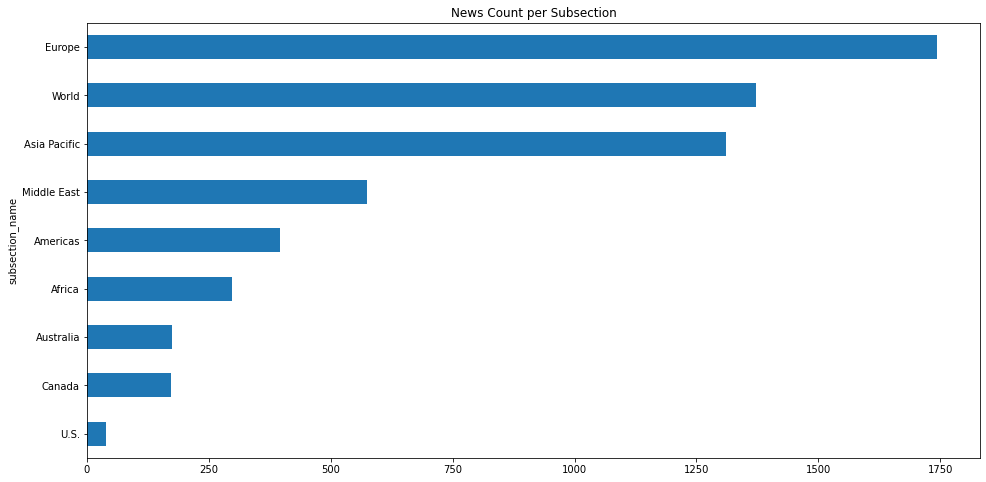

In [155]:
#for evaluation purposes we must take into account as well the amount of news per section
filtered_countries_df.groupby("subsection_name")["ID"].count().sort_values(ascending=True).plot.barh()
plt.title("News Count per Subsection")

The Vader visualization is actually much more explicative than the Text Blob one. We might see how the worst performing continent in terms of mount of bad news is Africa while the best performing is U.S. These results must take into account as well the amount of news per country. As we can see indeed, U.S. has the least amount of news whilst Africa is in the lower part of the plot. This might lead to an unbalanced result.. Also as we would expect, the world section have more of a normally distributed amount of good and bad news.

Let's visualize now our results on a world map

In [156]:
#retriving GeoJson continent boundaries from the web
continents = requests.get(
    "https://gist.githubusercontent.com/hrbrmstr/91ea5cc9474286c72838/raw/59421ff9b268ff0929b051ddafafbeb94a4c1910/continents.json"
).json()

In [157]:
#creating a continents df
continents_df = filtered_countries_df.groupby("subsection_name")[["negative", "positive", "neutral", "compound", "text_blob_sentiment"]].mean().reset_index()
continents_df.rename(columns={"subsection_name":"CONTINENT"}, inplace=True)
continents_df

CONTINENT  negative  positive   neutral  compound  text_blob_sentiment
0        Africa  0.156436  0.051413  0.792164 -0.567700             0.010189
1      Americas  0.131131  0.065023  0.803866 -0.326643             0.018763
2  Asia Pacific  0.123826  0.063147  0.813024 -0.313789             0.022165
3     Australia  0.096303  0.059823  0.843886 -0.192288             0.031768
4        Canada  0.090407  0.064297  0.845326 -0.128665             0.027855
5        Europe  0.115788  0.064861  0.819344 -0.262766             0.035713
6   Middle East  0.126664  0.065023  0.808329 -0.334071             0.035945
7          U.S.  0.072395  0.073211  0.854237  0.087511             0.034200
8         World  0.077178  0.069059  0.853765 -0.033516             0.068762

In [158]:
#mapping continents correctly
continents_df["CONTINENT"] = continents_df["CONTINENT"].map({
    "Africa":"Africa",
    "Americas":"South America",
    "Asia Pacific": "Asia",
    "Canada": "North America",
    "Middle East": "Asia",
    "U.S.":"North America",
    "Australia":"Australia",
    "Europe": "Europe"
    })

In [159]:
continents_df.dropna(inplace=True)
continents_df=continents_df.round(decimals=2)
continents_df.head(3)

CONTINENT  negative  positive  neutral  compound  text_blob_sentiment
0         Africa      0.16      0.05     0.79     -0.57                 0.01
1  South America      0.13      0.07     0.80     -0.33                 0.02
2           Asia      0.12      0.06     0.81     -0.31                 0.02

In [162]:
fig = px.choropleth_mapbox(continents_df, geojson=continents, locations='CONTINENT', featureidkey="properties.CONTINENT",
                           color='compound',
                           color_continuous_scale="Reds_r",
                           mapbox_style="carto-darkmatter",
                           hover_data=["compound","text_blob_sentiment"],
                           labels={
                               "compound":"Vader",
                               "text_blob_sentiment":"Text Blob"
                           },
                           zoom=1,
                           opacity=0.5,
                          )
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## 10 Conclusions

We arrived at the end of our journey to depict the status of the world and its health. We went trough time series analysis and a deeper look into sentiment scores. 

We saw how monthly wordclouds and word frequency plot can help to have a quick idea on what those months were about in terms of main topics. We found out how trough a simple word filter the main topics were mainly about conflicts and covid related news.

Time series analysis has been very helpful to understand if there is any pattern especially during these 12 months in the bad or positive news. We didn't find anything interesting, but going further with a tipic analysis like we did for Covid we saw how indeed there is a pattern and that we can even attempt a topic forecast. This part of the study might be the one that would need further exploration maybe analyzing more topics and their trend to be able to understand if any trend forecast is doable and reliable.

We then dived deeper in the sentiment score evaluation. For comparison purposed we introduced new pretrained models ending choosing the fastest one: Text Blob. Here as well we could go further with the study removing the time constrain and using more advanced models at the cost of a longer process time. We saw how there was a sensible difference between Vader and Text Blob evaluation being the first more polarized and the second more normally distributed. Despite this observation, the first four most positive and most negative topics are the same for both models. After, Text Blob seems more imprecise classifying Demonstrations, Protests and Riots between positive topics. Also we saw a sensible difference between these two models being Text Blob more positive biased and Vader more negative biased.

We then focussed our attention on a daily sentiment analysis and showed what were the worst and best days for both models. It again proved how less reliable Text Blob is, classifying all the positive news wrongly.

Finally we analyzed the sentiment analysis based on geography sections. Perhaps the most interesting visualization is the Vader sentiment per world zone. It clearly shows how different zones of the world performed in terms of the amount of bad and good news. In this case we saw how Africa have the biggest amount of negative news while U.S. the least. We must take into account as well the amount of news per each zone to make a proper evaluation: Europe had the most news while U.S. the least. It was interesting to see as well how globally the news are normally shaped being the positive and the negative news almost 50% for the World section. Also in the world plot we can see how Text Blob basically showed a positive outcome for all the continents while Vader has a more variate result.

All in all we can say that our scope has been fully fulfilled, we have been able to depict the world status trough a deeper analysis.

<a id="references_"></a>
# Refrences

[1] ELVIS, , Examining Gender and Race Bias in Sentiment Analysis Systems. Available: https://medium.com/dair-ai/examining-gender-and-race-bias-in-sentiment-analysis-systems-b04b269a653 [10/02/, 2021].

[2] DIMITRIS EFFROSYNIDIS, , Time Series Analysis with Theory, Plots, and Code Part 1. Available: https://towardsdatascience.com/time-series-analysis-with-theory-plots-and-code-part-1-dd3ea417d8c4 [10/02/, 2021].

[3] SHAY PALACHY, , Stationarity in time series analysis. Available: https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322 [10/02/, 2021].

[4] VINOD CHEDALAVADA, , Analysis of Time Series Data . Available: https://medium.com/analytics-vidhya/analysis-of-time-series-data-dad4afa56358 [10/02/, 2021].

[5] PANWAR ABHASH ANIL, , Introduction to Time Series Analysis and key concepts. Available: https://medium.com/analytics-vidhya/introduction-to-time-series-analysis-and-key-concepts-dbf6c394984f [10/02/, 2021].

[6] BEX, T., , How to Detect Random Walk and White Noise in Time Series Forecasting. Available: https://towardsdatascience.com/how-to-detect-random-walk-and-white-noise-in-time-series-forecasting-bdb5bbd4ef81 [10/02/, 2021].

[7] SELVA PRABHAKARAN, , KPSS Test for Stationarity. Available: https://www.machinelearningplus.com/time-series/kpss-test-for-stationarity/ [10/02/, 2021].

[8] TIM SMITH, , Autocorrelation. Available: https://www.investopedia.com/terms/a/autocorrelation.asp [10/02/, 2021].

[9] BEX, T., , Advanced Time Series Analysis in Python: Seasonality and Trend Analysis (Decomposition), Autocorrelation. Available: https://towardsdatascience.com/advanced-time-series-analysis-in-python-decomposition-autocorrelation-115aa64f475e [10/02/, 2021].

[10] PAUL J. LAVRAKAS, , Rolling Avarages. Available: https://methods.sagepub.com/reference/encyclopedia-of-survey-research-methods/n497.xml.

[11] DARIO RADEČIĆ, , Time Series From Scratch — Introduction to Time Series with Pandas. Available: https://towardsdatascience.com/time-series-from-scratch-introduction-to-time-series-with-pandas-347ac9c6b451.

[12] RYAN HOLBROOK and ALEXIS COOK, , Trend . Available: https://www.kaggle.com/ryanholbrook/trend.

[13] ADITYA BERI, , Sentiment Analysis using Vader. Available: https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664 [10/02/, 2022].

[14] C.J. Hutto, Vader Sentiment. Available: https://github.com/cjhutto/vaderSentiment [10/02/2022]

[15] twitter-roberta-base-sentiment. Available: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment?text=I+like+you.+I+love+you [10/02/2022]

[16] distilbert-base-uncased-finetuned-sst-2-english. Available: https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english [10/02/2022]

[17] Available: nlptown/bert-base-multilingual-uncased-sentiment [10/02/2022]

[18] Steven Loira, TextBlob: Simplified Text Processing. Available: https://textblob.readthedocs.io/en/dev/ [10/02/2022]